0    HUNTER-SYNC
1         HUNTER
2           PMFS
3     NOVA-RELAX
4           NOVA
5      NOVA-NOGC
Name: file_system, dtype: object


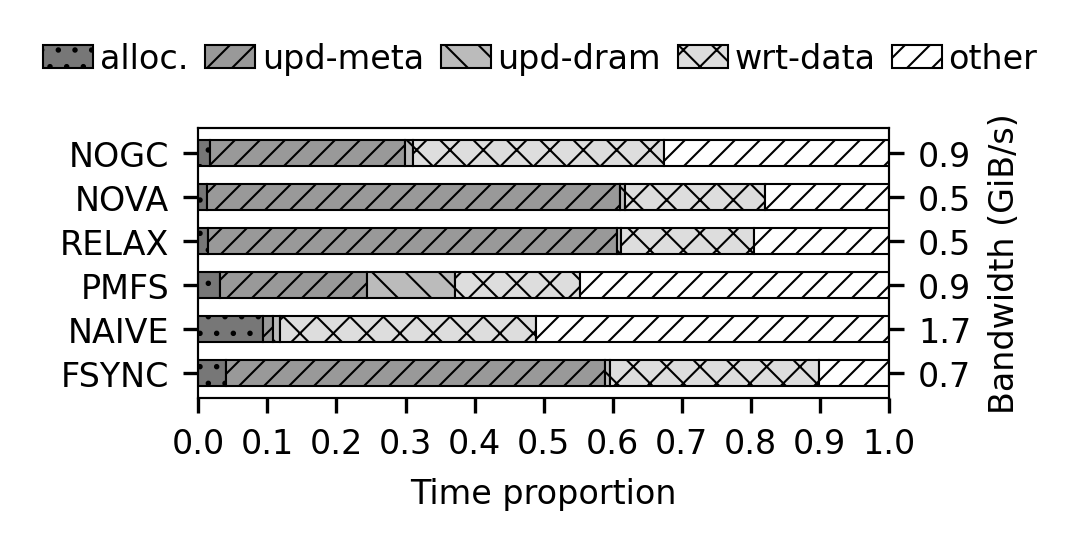

In [7]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

sort_dict = {
    "NOVA-NOGC": 6,
            "NOVA": 5,
      "NOVA-RELAX": 4,
            "PMFS": 3,
          "HUNTER": 2,
    "HUNTER-SYNC": 1
}
sort_df = pd.DataFrame(df['file_system'].map(sort_dict))
df = df.iloc[sort_df.sort_values(by = ["file_system"]).index]
df = df.reset_index().drop(columns=['index'])

# Plotting Settings
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_size_inches(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4))
fig.set_dpi(300)

bar_width = 1
patterns = ['...', '////', '\\\\\\', 'XXX', '////']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#777777", "#999999", "#bbbbbb", "#dddddd", "#ffffff"] 
# colors.reverse()
times = ["allocate", "update-meta", "update-dram", "write-data", "other"]

fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
tot = len(fss) * bar_width
x = [1, 2, 3, 4, 5, 6]

# normalize to 1
for i in range(0, 6):
    for time in times:
        df.loc[i, time] = df.iloc[i][time] / df.iloc[i]["total"]
    
global_points = []
print(fss)
for idx, fs in enumerate(fss):
    # points = []
    # for pivot in x:
    point = idx
    bottom = 0
    for i, time in enumerate(times):
        height = df[(df['file_system'] == fs)][time].iloc[0] 
        # / 1000
        # y = df[df['file_system'] == fs][time].tolist()
        # plt.bar(points[i], y, bar_width, color=colors[i], label=time, hatch=patterns[i])
        plt.barh(point, width=height, height=bar_width * 0.6, hatch=patterns[i], color=colors[i],  edgecolor='black',left=bottom, linewidth=0.5)
        bottom += height
    bw = round(df[df['file_system'] == fs]["bandwidth(MiB/s)"].iloc[0] / 1024, 2)
# Draw title
plt.xticks(np.linspace(0, 1, 11), fontsize=8)
plt.xlim(0, 1)
plt.xlabel('Time proportion', fontsize=8)
plt.yticks([_x - 1 for _x in x], labels=fss.map({
    "NOVA-NOGC": "NOGC",
            "NOVA": "NOVA",
      "NOVA-RELAX": "RELAX",
            "PMFS": "PMFS",
          "HUNTER": "NAIVE",
    "HUNTER-SYNC": "FSYNC"
}), fontsize=8)
ylim = ax.get_ylim()
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)


ax.twinx()
plt.ylim(ylim)
plt.yticks([_x - 1 for _x in x], labels=[round(df[df['file_system'] == fs]["bandwidth(MiB/s)"].iloc[0] / 1024, 1) for fs in fss], fontsize=8)
plt.ylabel('Bandwidth (GiB/s)', fontsize=8)
# plt.xlabel("File Size (GiB)", fontsize=8) 
ax = fig.gca()
lw = 0.5
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
# plt.tick_params(bottom=False, top=False, left=False, right=False)

fig.legend(pd.Series(times).map({
    "allocate": "alloc.",
    "update-meta": "upd-meta",
    "update-dram": "upd-dram",
    "write-data": "wrt-data",
    "other": "other",
}), loc='center', bbox_to_anchor=(0.5, 1.05), ncol=5, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5)

plt.tight_layout()

plt.savefig("./FIG-OverheadsBreakdown.pdf", bbox_inches='tight', pad_inches=0)
